Test project on Kaggle Titanic dataset.We use to predict whether people from Titanic survived or not using different features and Machine Learning models.After we compare mistakes from each way and choose the best.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

test1 = pd.read_csv("test.csv")
test = test1.copy()
train1 = pd.read_csv("train.csv")
train = train1.copy()


In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The page of data dictionary https://www.kaggle.com/c/titanic/data explains the various columns.

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


First of all we will try to use features Age, Sex, and PClass for our prediction model.   

Lets plot the age column,we can see that in some age ranges more passengers survived.So it's may be useful to separate this feature in categorical(binning).

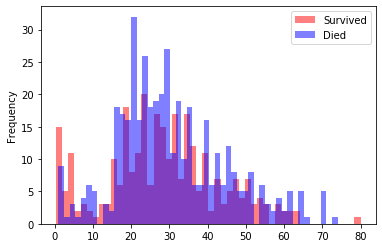

In [4]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

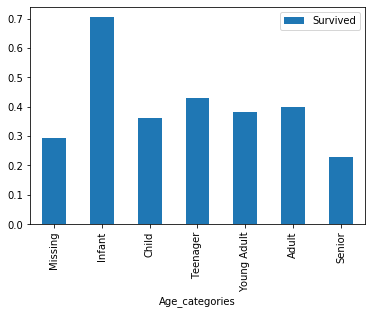

In [5]:
def process_age(df,cut_points,label_names):
    """Process the Age column into pre-defined labels"""
    
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

Let's create dummy columns for our categorical variables.

In [6]:
def create_dummies(df,column_name):
    """Create Dummy Columns from a single Column"""

    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

Let's split our data frame on training and test sets.After we will train Logistic Regression model on the training set and  count it's accuracy with the help of cross validation score and accuracy score metrics.

In [7]:
from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 

lr = LogisticRegression(solver='lbfgs')
scores = cross_val_score(lr, all_X, all_y, cv=10)
print(scores)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]


In [9]:
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='lbfgs')
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
accuracy

0.8100558659217877

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y,predictions)
cm

array([[96, 14],
       [20, 49]], dtype=int64)

Finally we can train our model on all training set,and see predictions for the test set.Push our model on kaggle and see the accuracy we will get.

In [11]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
lr = LogisticRegression(solver='lbfgs')
lr.fit(all_X,all_y)
prediction_y = lr.predict(test[columns])


In [12]:
test_ids = test["PassengerId"]
submission_df = {"PassengerId": test_ids,
                 "Survived": prediction_y}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission.csv",index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


We got 75,598% accuracy score on kaggle.Lets make our model better.

First model was predicted on Age,Sex and Pclass features.Now we will look at other columns.

In [13]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all'))

             SibSp       Parch        Fare Cabin Embarked
count   891.000000  891.000000  891.000000   204      889
unique         NaN         NaN         NaN   147        3
top            NaN         NaN         NaN    G6        S
freq           NaN         NaN         NaN     4      644
mean      0.523008    0.381594   32.204208   NaN      NaN
std       1.102743    0.806057   49.693429   NaN      NaN
min       0.000000    0.000000    0.000000   NaN      NaN
25%       0.000000    0.000000    7.910400   NaN      NaN
50%       0.000000    0.000000   14.454200   NaN      NaN
75%       1.000000    0.000000   31.000000   NaN      NaN
max       8.000000    6.000000  512.329200   NaN      NaN


Before using this features in our model we should make some preprocessing.

In [14]:
from sklearn.preprocessing import minmax_scale

test["Fare"] = test["Fare"].fillna(train["Fare"].mean())
columns = ["SibSp","Parch","Fare"]

train["Embarked"] = train["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].fillna("S")

train = create_dummies(train,"Embarked")
test = create_dummies(test,"Embarked")

for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    test[col + "_scaled"] = minmax_scale(test[col])

For selecting best features we can look on corelation cofficient for Logistic Regression model and chose best.

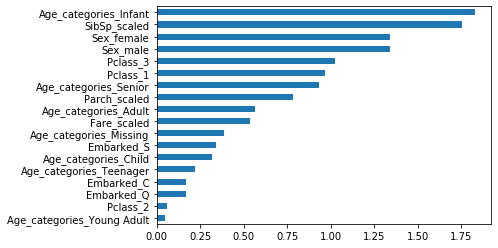

In [15]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']
lr = LogisticRegression(solver='lbfgs')
lr.fit(train[columns],train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=train[columns].columns).abs().sort_values()
feature_importance.plot.barh()
plt.show()

We'll train a new model with the top 8 scores and check our accuracy using cross validation.

In [16]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression(solver='lbfgs')
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
accuracy

0.8148019521053229

In [17]:
def process_fare(df,cut_points,label_names):
    """Process the Fare column into pre-defined bins """

    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
test = process_fare(test,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
test = create_dummies(test,"Fare_categories")

Also we can take some information from the name column,but first we should bin with six main column patterns.

In [18]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = test["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
test["Title"] = extracted_titles.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

test["Cabin_type"] = test["Cabin"].str[0]
test["Cabin_type"] = test["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

With the help of recursive feature elimination we can find best features for our model wich using all of our features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model.

In [19]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled','Sex_female','Sex_male',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]
lr = LogisticRegression(solver='lbfgs')
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns = all_X.columns[selector.support_]
optimized_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

Let's train model on this features.

In [20]:
all_X = train[optimized_columns]
all_y = train["Survived"]
lr = LogisticRegression(solver='lbfgs')
scores = cross_val_score(lr,all_X,all_y,cv=10)
accuracy = scores.mean()
accuracy

0.8226549199863807

In [21]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(all_X,all_y)
test_predictions = lr.predict(test[optimized_columns])

test_ids = test["PassengerId"]lr = LogisticRegression(solver='lbfgs')
lr.fit(all_X,all_y)
test_predictions = lr.predict(test[optimized_columns]
submission_df = {"PassengerId": test_ids,
                 "Survived": test_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_2.csv",index=False)

Kaggle shows 78,468% accuracy that by 2.8% better than our last prediction.

Now let's try different models to improve our results.

In [22]:
all_X = train[columns]
all_y = train["Survived"]
lr = LogisticRegression(solver='lbfgs')
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy_lr = scores.mean()
accuracy_lr


0.8204954034729317

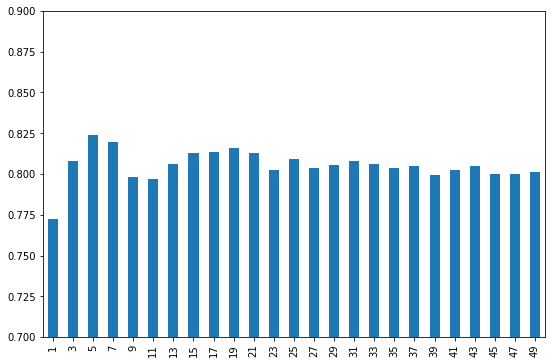

In [23]:
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.7,0.9))
    plt.show()

knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, all_X, all_y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn

plot_dict(knn_scores)

In [24]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute',"kd_tree"],
    "p": [1,2]
    
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10,iid=True)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

In [25]:
print(best_params)
print(best_score)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.8282828282828283


In [26]:
best_knn = grid.best_estimator_
test_predictions = best_knn.predict(test[columns])

test_ids = test["PassengerId"]
submission_df = {"PassengerId": test_ids,
                 "Survived": test_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_3.csv",index=False)

Kaggle shew 77,9% predictions accuracy.Knn model was a bad choice.Let's try another algorithm.

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10,random_state=1)
scores = cross_val_score(clf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()
accuracy_rf

0.8216570196345477

In [28]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
}

clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_
print(best_params)
print(best_score)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 9}
0.8316498316498316


In [29]:
best_rf = grid.best_estimator_
test_predictions = best_rf.predict(test[columns])

holdout_ids = test["PassengerId"]
submission_df = {"PassengerId": test_ids,
                 "Survived": test_predictions}TT
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_4.csv",index=False)

77,9%

In [40]:
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

hyperparameters = {"penalty":['l1','l2'],
                   "C":np.logspace(0, 4, 10)
}

lr = LogisticRegression()
grid = GridSearchCV(lr,param_grid=hyperparameters,cv=10)
grid.fit(train[optimized_columns],train["Survived"])
best_params = grid.best_params_
best_score = grid.best_score_
print(best_params)
print(best_score)

{'C': 1.0, 'penalty': 'l1'}
0.8226711560044894
